# Model Notebook
I have decided to implement 3 different models. The model that returns the best rmse gets to predict future.
1. SARIMAX
2. FBProphet
3. LightGBM

In [204]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import statsmodels.api as sm

from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import datetime

from tqdm import tqdm
from fbprophet import Prophet
import holidays


import lightgbm as lgb
from sklearn.model_selection import train_test_split


In [47]:
def return_series(csv_path):
    """
    
    """
    
    def parse(x):
        return datetime.datetime.strptime(x, '%m/%d/%Y %H')
    
    df = pd.read_csv(csv_path, parse_dates=[['Date','Hour']], date_parser=parse)
    
    conditions = [
    df['Plaza ID'].eq(21) | df['Plaza ID'].eq(1),
    df['Plaza ID'].eq(22) | df['Plaza ID'].eq(2),
    df['Plaza ID'].eq(23) | df['Plaza ID'].eq(3),
    df['Plaza ID'].eq(24) | df['Plaza ID'].eq(4),
    df['Plaza ID'].eq(25) | df['Plaza ID'].eq(5),
    df['Plaza ID'].eq(26) | df['Plaza ID'].eq(6),
    df['Plaza ID'].eq(27) | df['Plaza ID'].eq(7),
    df['Plaza ID'].eq(28) | df['Plaza ID'].eq(8),
    df['Plaza ID'].eq(29) | df['Plaza ID'].eq(9),
    df['Plaza ID'].eq(30) | df['Plaza ID'].eq(11)
    ]
    choices = [
        'Triboro',
        'Triboro',
        'Whitestone',
        'Henry Hudson',
        'Marine Parkway',
        'Cross Bay',
        'Queens Midtown',
        'Brooklyn Battery',
        'Throgs Neck',
        'Verrazano'
    ]
    df['plaza_id'] = np.select(conditions, choices, 0)
    
    df['total_count'] = df['# Vehicles - E-ZPass'] + df['# Vehicles - VToll']
    
    sub_df = df[['Date_Hour', 'plaza_id', 'total_count']]
    sub_df.columns = ['datetime', 'plaza_id', 'total_count']
    sub_df.set_index('datetime', inplace=True)
    sub_df = sub_df.groupby('plaza_id')['total_count'].resample('1D').sum()
    
    return sub_df


In [48]:
df = return_series('mta.csv')

In [50]:
_df = df.unstack().T
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [51]:
holidays_2018_2020 = []
for year in [2018, 2019, 2020]:
    for date in holidays.UnitedStates(years=year).items():
        holidays_2018_2020.append(date[0])
        
bridges = ['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway',
       'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone']

In [52]:
def date_features(_df):
    _df['month'] = _df.index.month
    _df['dayofweek'] = _df.index.dayofweek
    _df['year'] = _df.index.year
    _df['week'] = _df.index.isocalendar().week
    _df['day'] = _df.index.day
    _df['quarter'] = _df.index.quarter


    conditions = [
        (_df.index >= '2020-03-21') & (_df.index < '2020-06-08'),
        (_df.index >= '2020-06-08') & (_df.index < '2020-06-22'),
        (_df.index >= '2020-06-22') & (_df.index < '2020-07-06'),
        (_df.index >= '2020-07-06') & (_df.index < '2020-07-19'),
        (_df.index >= '2020-07-19')
    ]

    choices = [
        0,
        1,
        2,
        3,
        4
    ]

    _df['Phase'] = np.select(conditions, choices, -1)
    _df['weekend'] = (_df.index.dayofweek>4).astype(int)
    _df['holiday'] = np.where(_df.index.isin(holidays_2018_2020), 1, 0)
    return _df



In [53]:
_df = date_features(_df)
print(_df.shape)
_df.head()

(986, 18)


plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone,month,dayofweek,year,week,day,quarter,Phase,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,
2018-01-01,29163,13705,46540,12118,54907,98346,140775,81923,109286,1,0,2018,1,1,1,-1,0,1
2018-01-02,47160,21875,60610,19887,67000,106264,164930,95649,117211,1,1,2018,1,2,1,-1,0,0
2018-01-03,54005,24607,67983,22067,71725,115952,175150,103506,123974,1,2,2018,1,3,1,-1,0,0
2018-01-04,20484,8303,14502,6167,26625,28406,64137,37820,38114,1,3,2018,1,4,1,-1,0,0
2018-01-05,38007,16839,49850,13929,55153,80477,135253,74375,91229,1,4,2018,1,5,1,-1,0,0


In [56]:
ohe = OneHotEncoder(drop='first')
categorical_columns = ['month', 'dayofweek', 'quarter', 'Phase']
_df_ohe = ohe.fit_transform(_df[categorical_columns]).toarray()
_df_ohe_df = pd.DataFrame(data = _df_ohe,
                           index = _df.index,
                          columns = ohe.get_feature_names(categorical_columns))

_df_merged = _df.merge(_df_ohe_df, left_index=True, right_index=True)
_df_ohe_df['weekend'] = _df['weekend']
_df_ohe_df['holiday'] = _df['holiday']
_df_ohe_df.shape

,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,...,quarter_2,quarter_3,quarter_4,Phase_0,Phase_1,Phase_2,Phase_3,Phase_4,weekend,holiday
datetime,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
2018-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2018-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2018-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2018-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


### SARIMAX

In [116]:
def return_arima_rmse(bridge, _order, _seasonal_order, _trend):
    """
    returns arima rmse
    """
    tr_start,tr_end = '2018-01-01','2020-08-22'
    te_start,te_end = '2020-08-23','2020-09-12'
    tra = _df_merged[tr_start:tr_end][bridge]
    tes = _df_merged[te_start:te_end][bridge]
    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    
    model_SARIMAX = SARIMAX(tra, order=_order, seasonal_order= _seasonal_order, exog = exog_train, trend = _trend,
                        freq='D', enforce_stationarity=False, enforce_invertibility=False)
    results = model_SARIMAX.fit(maxiter=1000)
    
    pred = results.predict(te_start,te_end, exog = exog_test)
    return np.sqrt(mean_squared_error(tes,pred))

In [121]:
bridges = ['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway',
       'Queens Midtown', 'Throgs Neck', 'Triboro',
       'Verrazano', 'Whitestone']

_sarimax_rmse = []
for i in tqdm(bridges):
    _sarimax_rmse.append(return_arima_rmse(i, (1,1,2), (1,0,1,7), 'n'))

100%|██████████| 9/9 [01:14<00:00,  8.30s/it]


In [122]:
_results_df = pd.DataFrame()
_results_df['bridges'] = bridges
_results_df['SARIMAX'] = _sarimax_rmse
_results_df

,bridges,SARIMAX
0,Brooklyn Battery,4059.236929
1,Cross Bay,3386.311987
2,Henry Hudson,4666.721500
3,Marine Parkway,4887.211083
4,Queens Midtown,4018.266503
5,Throgs Neck,7534.044095
6,Triboro,8603.557969
7,Verrazano,3833.719124
8,Whitestone,7176.207966


### FBProphet

In [128]:
def return_prophet_rmse(bridge):
    """
    returns arima rmse
    """
    
    lockdown = pd.DataFrame({
      'holiday': 'lockdown',
      'ds': pd.date_range(start='2020-03-21', end='2020-06-07'),
      'lower_window': 0,
      'upper_window': 1,
    })
    phase_1 = pd.DataFrame({
      'holiday': 'Phase_1',
      'ds': pd.date_range(start='2020-06-08', end='2020-06-21'),
      'lower_window': 0,
      'upper_window': 1,
    })
    phase_2 = pd.DataFrame({
      'holiday': 'Phase_2',
      'ds': pd.date_range(start='2020-06-22', end='2020-07-05'),
      'lower_window': 0,
      'upper_window': 1,
    })
    phase_3 = pd.DataFrame({
      'holiday': 'Phase_3',
      'ds': pd.date_range(start='2020-07-06', end='2020-07-18'),
      'lower_window': 0,
      'upper_window': 1,
    })
    phase_4 = pd.DataFrame({
      'holiday': 'Phase_4',
      'ds': pd.date_range(start='2020-07-19', end='2020-12-31'),
      'lower_window': 0,
      'upper_window': 1,
    })


    holidays = pd.concat((lockdown, phase_1, phase_2, phase_3, phase_4))

    tr_start,tr_end = '2018-01-01','2020-08-22'
    te_start,te_end = '2020-08-23','2020-09-12'
    tra = _df_merged[tr_start:tr_end][bridge]
    tes = _df_merged[te_start:te_end][bridge]
    exog_train = _df_ohe_df[tr_start:tr_end]
    exog_test = _df_ohe_df[te_start:te_end]
    tra = tra.reset_index()
    tra.columns = ['ds','y']
    tes = tes.reset_index()
    tes.columns = ['ds','y']
    
    
    m = Prophet(holidays=holidays,
           changepoint_prior_scale= 0.1,
                      holidays_prior_scale = 0.1,
                      n_changepoints = 100,
                      seasonality_mode = 'additive',
                      weekly_seasonality=True,
                      daily_seasonality = True,
                      yearly_seasonality = True,
                      interval_width=0.95)
    
    m.fit(tra)
    
    future = pd.DataFrame(data= pd.date_range(start= '2020-08-23', end = '2020-09-12'), columns =['ds'])
    
    
    pred = m.predict(future)
    return np.sqrt(mean_squared_error(tes['y'],pred['yhat']))

In [130]:
fb_prophet_1 = []
for i in tqdm(bridges):
    fb_prophet_1.append(return_prophet_rmse(i))
    
_results_df['FB_prophet_1'] = fb_prophet_1
_results_df

100%|██████████| 9/9 [01:18<00:00,  8.76s/it]


,bridges,SARIMAX,FB_prophet_1
0,Brooklyn Battery,4059.236929,5904.339532
1,Cross Bay,3386.311987,3726.713876
2,Henry Hudson,4666.721500,5008.615510
3,Marine Parkway,4887.211083,6013.452054
4,Queens Midtown,4018.266503,7319.058074
5,Throgs Neck,7534.044095,7029.734263
6,Triboro,8603.557969,10313.827790
7,Verrazano,3833.719124,4824.876115
8,Whitestone,7176.207966,6486.419116


### LightGBM

In [133]:
_df = df.unstack().T
_df = _df['2018':].copy()
for i in _df.columns:
    _df[i] = _df[i].replace(to_replace=0, method='ffill')

In [135]:
_df.reset_index(inplace=True)
_df

plaza_id,datetime,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone
0,2018-01-01,29163,13705,46540,12118,54907,98346,140775,81923,109286
1,2018-01-02,47160,21875,60610,19887,67000,106264,164930,95649,117211
2,2018-01-03,54005,24607,67983,22067,71725,115952,175150,103506,123974
3,2018-01-04,20484,8303,14502,6167,26625,28406,64137,37820,38114
4,2018-01-05,38007,16839,49850,13929,55153,80477,135253,74375,91229
...,...,...,...,...,...,...,...,...,...,...
981,2020-09-08,55105,24644,60591,25524,66662,106502,164588,100146,121270
982,2020-09-09,56553,22692,62026,22821,67238,104707,163610,99250,118513
983,2020-09-10,55672,20742,60627,20495,65909,100158,159519,97574,114546
984,2020-09-11,56878,24493,70659,24483,73386,111209,178758,107214,131970


In [205]:
_df_melt = pd.melt(_df, id_vars=['datetime'], value_vars=['Brooklyn Battery', 'Cross Bay', 'Henry Hudson', 'Marine Parkway', 
                                                        'Queens Midtown', 'Throgs Neck', 'Triboro', 'Verrazano', 'Whitestone'])
_df_melt.set_index('datetime', inplace=True)


In [206]:

le = LabelEncoder()
_df_melt['plaza_id'] = le.fit_transform(_df_melt['plaza_id'])
_df_melt

,plaza_id,value
datetime,,
2018-01-01,0,29163
2018-01-02,0,47160
2018-01-03,0,54005
2018-01-04,0,20484
2018-01-05,0,38007
...,...,...
2020-09-08,8,121270
2020-09-09,8,118513
2020-09-10,8,114546


In [207]:
_df_melt = date_features(_df_melt)
_df_melt.reset_index(inplace=True)

In [208]:
train_set = _df_melt.loc[_df_melt['datetime'] <= '2020-08-22'].copy(deep=True)
test_set = _df_melt.loc[(_df_melt['datetime'] > '2020-08-22') & (_df_melt['datetime'] <= '2020-09-12')].copy(deep=True)
pred_set = _df_melt.loc[(_df_melt['datetime'] > '2020-08-22')].copy(deep=True)
pred_set['value'] = np.nan
# pred_set.head()

In [209]:
def date_lags(_df):
    """
    creates lag 7 and lag 28 features from values.
    creates ma7_lag7, ma7_lag28, ma28_lag7, ma28_lag28.
    
    """
    _df['lag_7'] = _df[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(7)
    _df['lag_28'] = _df[['plaza_id', 'value']].groupby('plaza_id')['value'].shift(28)

    
    _df['mean_lag7_roll7'] = _df[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag7_roll28'] = _df[['plaza_id', 'lag_7']].groupby('plaza_id')['lag_7'].apply(lambda x: x.rolling(28).mean())
    _df['mean_lag28_roll7'] = _df[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(7).mean())
    _df['mean_lag28_roll28'] = _df[['plaza_id', 'lag_28']].groupby('plaza_id')['lag_28'].apply(lambda x: x.rolling(28).mean())
    _df['week'] = _df['week'].astype('int64')
    
    return _df

In [210]:
train_set = date_lags(train_set)
# train_set

In [211]:
categorical_features = ['plaza_id', 'month', 'dayofweek', 'year', 'week', 'day', 'Phase', 'weekend', 'holiday']
useless_cols = ['datetime', 'value']
train_cols = [x for x in train_set.columns if x not in useless_cols]
_X = train_set[train_cols]
_y = train_set['value']

In [212]:

X_train, X_valid, y_train, y_valid = train_test_split(_X, _y, random_state=42, test_size=0.2)

In [213]:
train_data = lgb.Dataset(X_train, label = y_train, categorical_feature=categorical_features, free_raw_data=False)
y_valid_data = lgb.Dataset(X_valid, label = y_valid, categorical_feature=categorical_features, free_raw_data=False) 


In [214]:
params = {
    'objective': 'poisson',
    'boosting': 'gbdt',
    'max_depth': 45,
    'num_leaves': 36,
    'metric' :'rmse',
    'learning_rate' : 0.05,
    'sub_row' : 0.75,
    'bagging_fraction' : 0.5044815500240623,
    'feature_fraction': 0.7185302979559964,
    'lambda_l1' : 0.1000431724928434,
    'verbosity': 1,
    'num_iterations' : 4000

}


In [215]:
m_lgb = lgb.train(params, train_data, valid_sets = y_valid_data, verbose_eval=100)

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

C:\Users\albert\Anaconda3\lib\site-packages\lightgbm\basic.py:1291: UserWarning:

Using categorical_feature in Dataset.



[100]	valid_0's rmse: 9631.35
[200]	valid_0's rmse: 7813.94
[300]	valid_0's rmse: 6992.34
[400]	valid_0's rmse: 6615.39
[500]	valid_0's rmse: 6402.04
[600]	valid_0's rmse: 6250.17
[700]	valid_0's rmse: 6100.65
[800]	valid_0's rmse: 6025.52
[900]	valid_0's rmse: 5959.76
[1000]	valid_0's rmse: 5898.53
[1100]	valid_0's rmse: 5848.32
[1200]	valid_0's rmse: 5798.34
[1300]	valid_0's rmse: 5755.58
[1400]	valid_0's rmse: 5723.66
[1500]	valid_0's rmse: 5698.07
[1600]	valid_0's rmse: 5667.65
[1700]	valid_0's rmse: 5645.74
[1800]	valid_0's rmse: 5622.56
[1900]	valid_0's rmse: 5613.05
[2000]	valid_0's rmse: 5598.65
[2100]	valid_0's rmse: 5578.05
[2200]	valid_0's rmse: 5562.06
[2300]	valid_0's rmse: 5554.48
[2400]	valid_0's rmse: 5545.52
[2500]	valid_0's rmse: 5538.09
[2600]	valid_0's rmse: 5531.17
[2700]	valid_0's rmse: 5524.76
[2800]	valid_0's rmse: 5516.05
[2900]	valid_0's rmse: 5514.7
[3000]	valid_0's rmse: 5511.76
[3100]	valid_0's rmse: 5509.64
[3200]	valid_0's rmse: 5506.3
[3300]	valid_0's rm

In [216]:
train_roll = train_set.copy(deep=True)
try:
    for i in range(1,20):
        _to_pred = pred_set.loc[pred_set['datetime'].isin(pd.date_range(start='2020-08-16', end='2020-08-22') + datetime.timedelta(days= i * 7))].copy()
        _first_concat = pd.concat([train_roll, _to_pred])
        _first_concat = date_lags(_first_concat)
        _to_pred = _first_concat.loc[_first_concat['datetime'].isin(pd.date_range(start='2020-08-16', end='2020-08-22') + datetime.timedelta(days=i * 7))].copy()
        _to_pred_feats = _to_pred[train_cols]
        first_pred = m_lgb.predict(_to_pred_feats)
        _to_pred['value'] = first_pred
        train_roll = pd.concat([train_roll, _to_pred])
except:
    print('end of loop')

end of loop


In [217]:
_lgbm_pred = train_roll.loc[train_roll['datetime'].isin(pd.date_range('2020-08-23', '2020-09-12'))][['datetime', 'plaza_id', 'value']]
# _lgbm_pred

,datetime,plaza_id,value
965,2020-08-23,0,33150.264328
966,2020-08-24,0,49446.026618
967,2020-08-25,0,52530.799563
968,2020-08-26,0,52634.492804
969,2020-08-27,0,56514.221944
...,...,...,...
8869,2020-09-08,8,124840.333411
8870,2020-09-09,8,123322.826828
8871,2020-09-10,8,126205.326791
8872,2020-09-11,8,131061.749834


In [219]:
_lgbm_pred['plaza_id'] = le.inverse_transform(_lgbm_pred['plaza_id'])
# _lgbm_pred

,datetime,plaza_id,value
965,2020-08-23,Brooklyn Battery,33150.264328
966,2020-08-24,Brooklyn Battery,49446.026618
967,2020-08-25,Brooklyn Battery,52530.799563
968,2020-08-26,Brooklyn Battery,52634.492804
969,2020-08-27,Brooklyn Battery,56514.221944
...,...,...,...
8869,2020-09-08,Whitestone,124840.333411
8870,2020-09-09,Whitestone,123322.826828
8871,2020-09-10,Whitestone,126205.326791
8872,2020-09-11,Whitestone,131061.749834


In [221]:
_lgbm_pivot_pred = _lgbm_pred.pivot(index='datetime', columns='plaza_id', values='value')
# _lgbm_pivot_pred

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone
datetime,,,,,,,,,
2020-08-23,33150.264328,20900.105414,44549.304573,21307.057173,42876.952252,103757.598080,139354.350311,87824.780950,123371.230545
2020-08-24,49446.026618,24247.214722,57076.605409,24225.405127,61100.457889,104301.056975,161870.025410,97789.505754,125393.599610
2020-08-25,52530.799563,23722.934519,58063.372625,24192.494243,64313.909881,102899.774592,158272.073089,97212.879714,125396.568499
2020-08-26,52634.492804,25762.992013,59083.543438,26063.858206,64739.053935,105505.015604,162956.932889,99607.578507,129292.142320
2020-08-27,56514.221944,27717.359482,64628.252331,27035.236422,69970.831007,111895.710443,168612.004439,105695.297859,135497.043505
2020-08-28,53832.605729,25494.795446,64305.040793,25374.563720,69924.218344,110667.309962,175964.226557,106257.614158,141845.869286
2020-08-29,38782.840290,26215.539146,54518.153133,26909.693244,51053.592802,112855.606888,153197.458164,99107.389252,134949.676614
2020-08-30,35320.688965,24078.038295,46478.163027,25872.123584,43613.368974,104329.284170,138453.146969,87242.876240,127864.820554
2020-08-31,51463.920675,22395.857467,60226.998830,22955.649370,65810.638338,101101.284855,158098.613865,96920.396792,125611.893192


In [226]:
# test_set['plaza_id'] = le.inverse_transform(test_set['plaza_id'])
test_set_pivot = test_set.pivot(index='datetime', columns = 'plaza_id', values='value')
# test_set_pivot

plaza_id,Brooklyn Battery,Cross Bay,Henry Hudson,Marine Parkway,Queens Midtown,Throgs Neck,Triboro,Verrazano,Whitestone
datetime,,,,,,,,,
2020-08-23,33512,22363,47402,26111,46676,115550,137479,88750,122662
2020-08-24,52900,24870,58620,25249,62355,105411,156475,98132,124869
2020-08-25,53262,25487,59695,26615,65038,103657,158012,98894,123245
2020-08-26,56023,26631,62991,28386,67172,110366,164094,103462,127881
2020-08-27,56449,23665,61787,24187,69279,105496,162178,101730,131813
2020-08-28,55428,27019,69061,27897,72177,114212,174204,105089,140436
2020-08-29,27376,17085,40655,14836,41910,93826,126361,84500,107399
2020-08-30,40607,27220,55131,31796,53782,126538,150338,92270,126998
2020-08-31,53652,22012,55362,21696,64731,107748,160755,99113,124618


In [228]:
_lgbm_rmse = []
for i in bridges:
    _lgbm_rmse.append(np.sqrt(mean_squared_error(test_set_pivot[i], _lgbm_pivot_pred[i])))

In [231]:
_results_df['LGBM'] = _lgbm_rmse

In [295]:
_results_df.set_index('bridges', inplace=True)
_results_df

,SARIMAX,FB_prophet_1,LGBM
bridges,,,
Brooklyn Battery,4059.236929,5904.339532,3880.587483
Cross Bay,3386.311987,3726.713876,3292.606688
Henry Hudson,4666.721500,5008.615510,4696.378329
Marine Parkway,4887.211083,6013.452054,4915.269861
Queens Midtown,4018.266503,7319.058074,5052.342745
Throgs Neck,7534.044095,7029.734263,9862.318864
Triboro,8603.557969,10313.827790,8204.315079
Verrazano,3833.719124,4824.876115,4401.293122
Whitestone,7176.207966,6486.419116,7088.434609


In [297]:
_results_df.sum(axis=0)

SARIMAX         48165.277154
FB_prophet_1    56627.036330
LGBM            51393.546779
dtype: float64

In [235]:
pred_far = pd.DataFrame()
pred_far['datetime'] = pd.date_range(start='2020-09-13',end='2020-12-31')
pred_far.set_index('datetime', inplace=True)
pred_far = date_features(pred_far)
_far_ohe = ohe.transform(pred_far[categorical_columns]).toarray()
_far_ohe_df = pd.DataFrame(data = _far_ohe,
                          index = pred_far.index,
                          columns = ohe.get_feature_names(categorical_columns))

_far_ohe_df['weekend'] = pred_far['weekend']
_far_ohe_df['holiday'] = np.where(_far_ohe_df.index.isin(holidays_2018_2020), 1, 0)

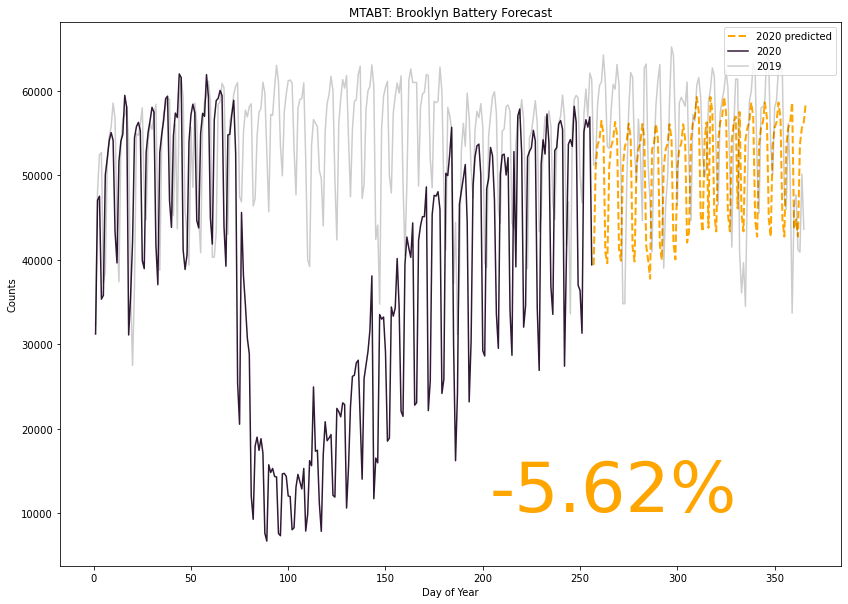

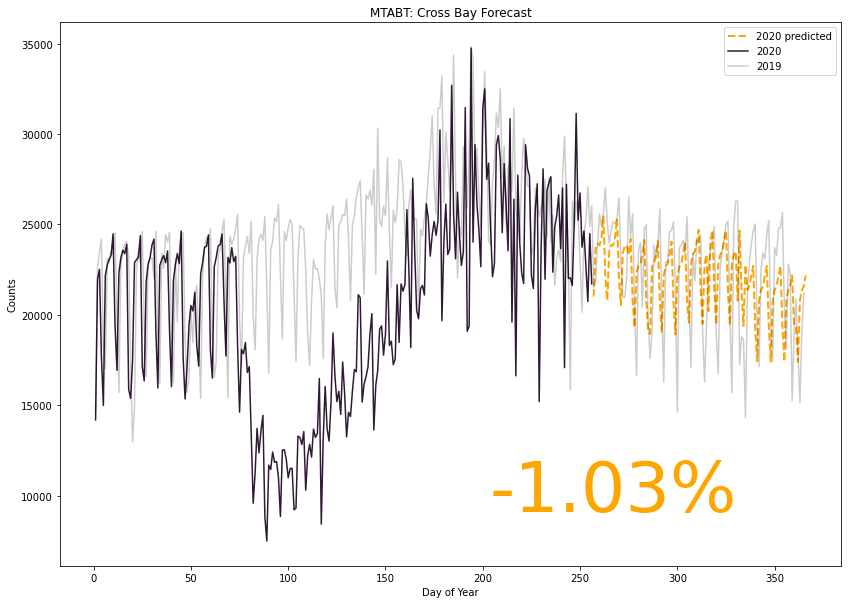

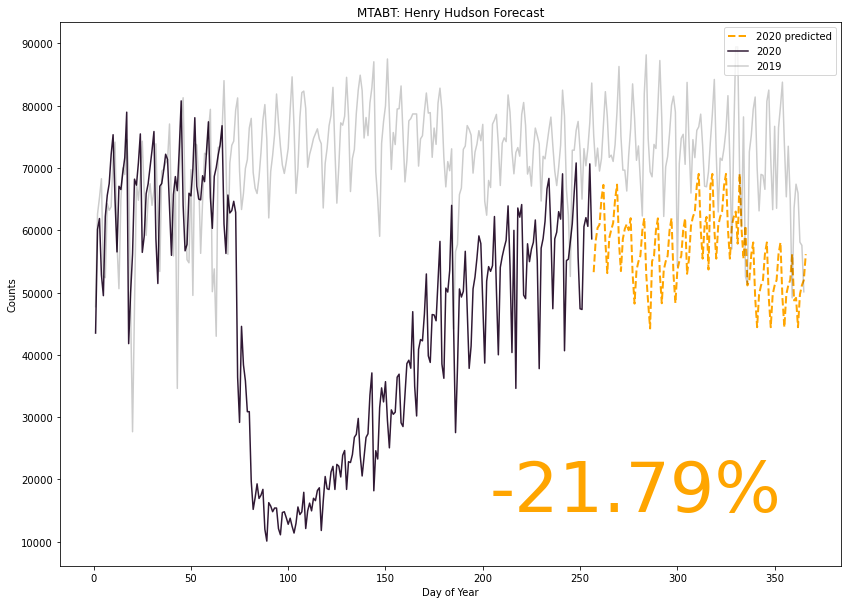

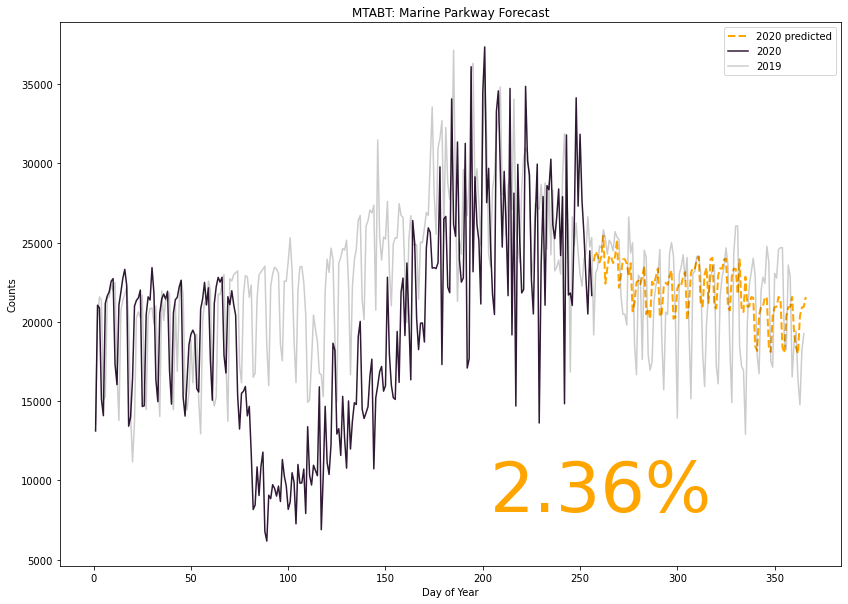

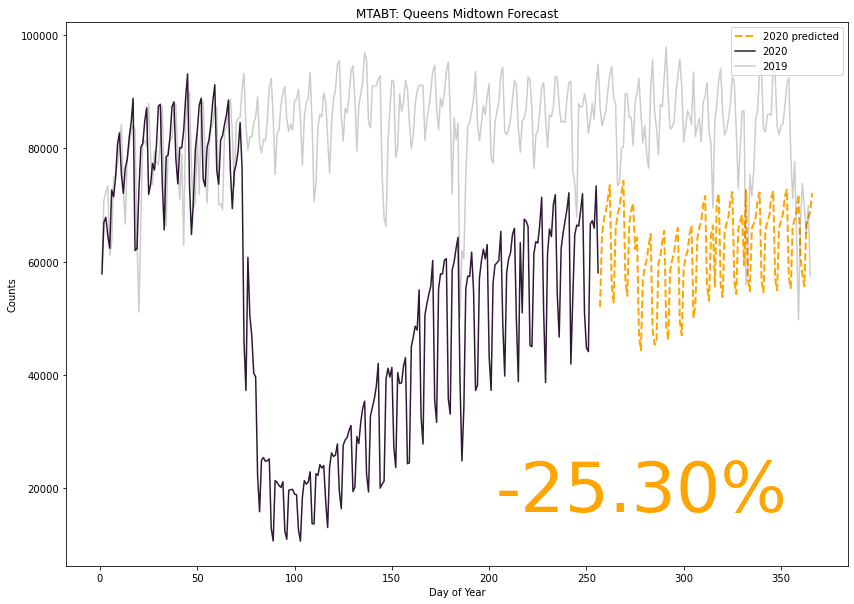

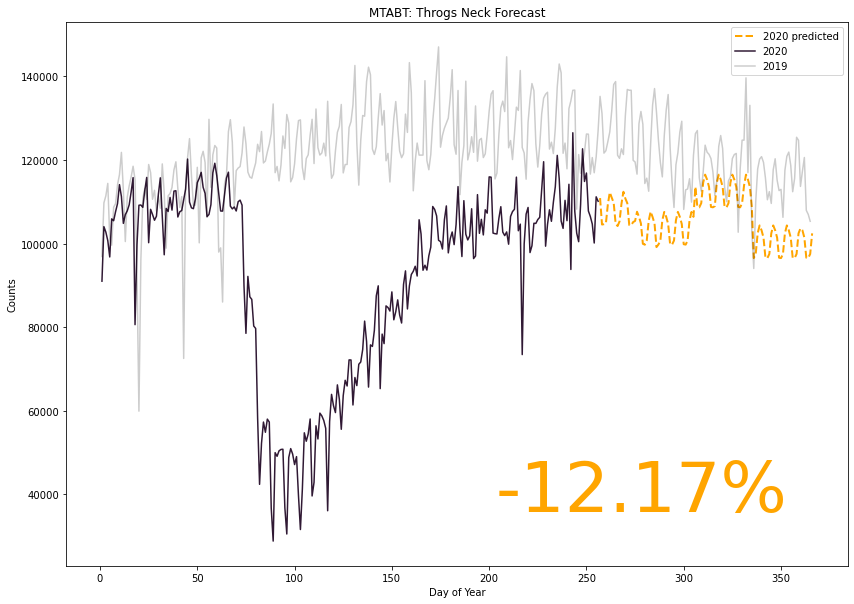

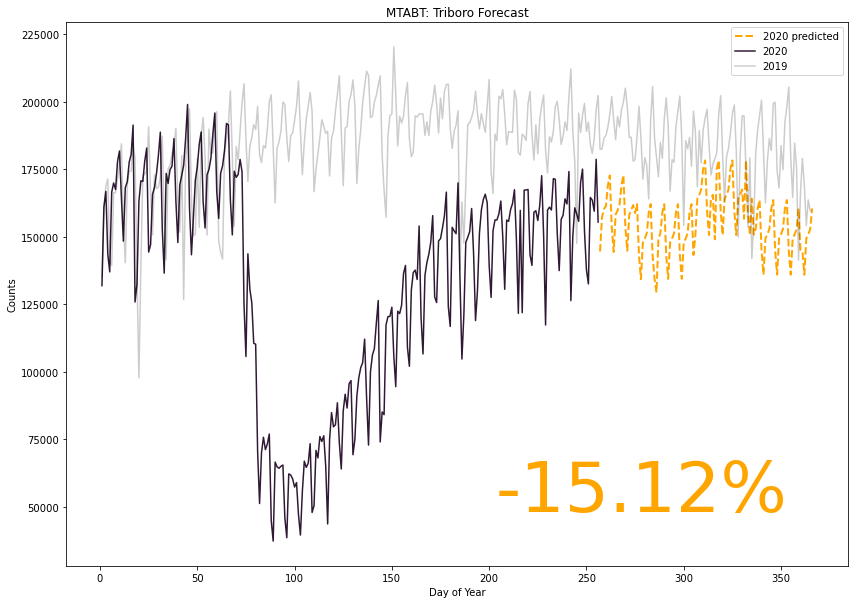

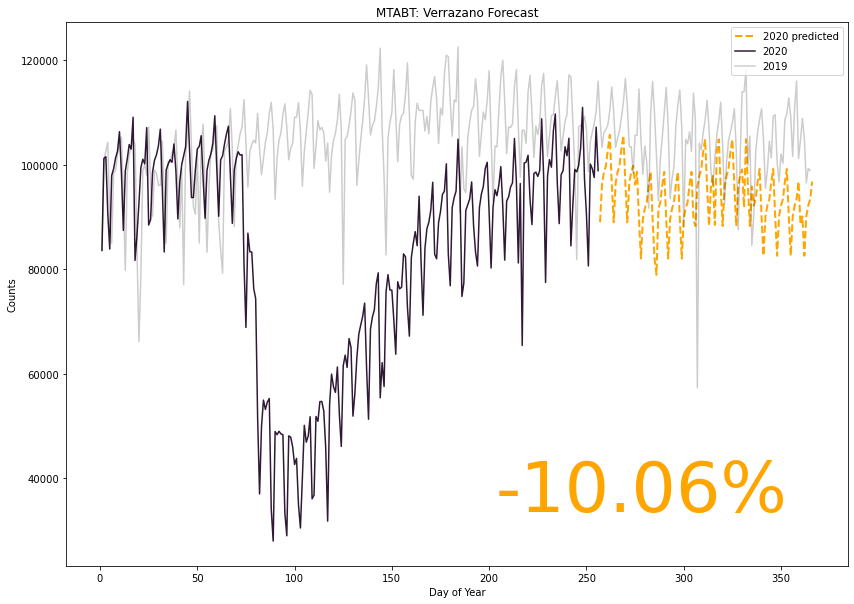

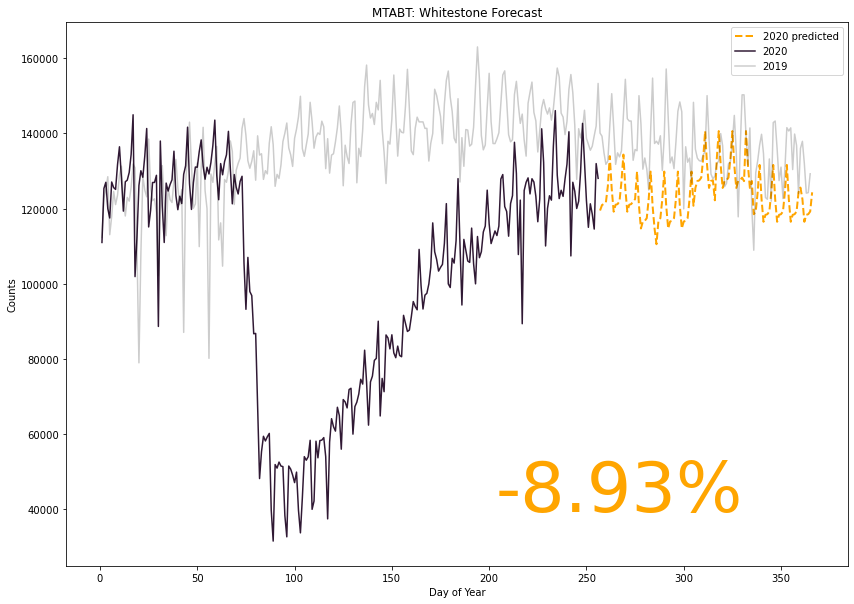

In [288]:
for i in bridges:
    model_SARIMAX = SARIMAX(_df_merged[i],order=(1,1,2), seasonal_order=(1,0,1,7), trend = 'n', exog = _df_ohe_df,
                    freq='D', enforce_stationarity=False, enforce_invertibility=False)
    results = model_SARIMAX.fit()
    far_pred = results.predict('2020-09-13', '2020-12-31', exog= _far_ohe_df)
    plt.figure(figsize=(14,10))
    plt.plot(_far_ohe_df.index.dayofyear, far_pred, color = 'orange', linewidth=2,linestyle = '--', label= '2020 predicted')
    plt.plot(_df_merged['2020'].index.dayofyear, _df_merged['2020'][i], color = '#301934',label = '2020')
    plt.plot(_df_merged['2019'].index.dayofyear, _df_merged['2019'][i], color = 'black', alpha = 0.2, label = '2019')
    plt.legend(loc='upper right')
    plt.xlabel('Day of Year')
    plt.ylabel('Counts')
    plt.title('MTABT: {} Forecast'.format(i))
    _percent_change = (far_pred.mean() - _df_merged['2019-09-13':'2019-12-31'][i].mean())/_df_merged['2019-09-13':'2019-12-31'][i].mean() * 100
    plt.annotate('{:.2f}%'.format(_percent_change), xy=(0.55, 0.10), xycoords='axes fraction', fontsize=70, color = 'orange')
    plt.savefig('{} forecast'.format(i), bbox_inches ='tight', pad_inches=0.5)
    plt.show();